# Data Preparation

In [1]:
from google.colab import drive # the real images data files take too long (about 17 minutes) to be downloaded, so we just mount it
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!tar -xzf /content/drive/MyDrive/nuimages/nuimages-v1.0-all-metadata.tgz && tar -xzf /content/drive/MyDrive/nuimages/nuimages-v1.0-all-samples.tgz # this will take about 7 minutes

In [3]:
drive.flush_and_unmount()

In [ ]:
!rm -rf train2017/ val2017/ annotations/ train.txt val.txt train.json val.json

In [4]:
!mkdir train2017 val2017 annotations

In [5]:
import sys
sys.path.append('/content/') # path where data_preparation.py is. Modify accordingly if needed

# import importlib # use this if you make changes to the data_preparation.py and want to reflect the changes in the notebook
# importlib.reload(data_preparation)

import data_preparation

In [6]:
train_df, val_df, class_list = data_preparation.get_df_and_class_list('/content/', 100, 100, train_random_sample=False, val_random_sample=False, class_type = "attribute_only")

In [7]:
data_preparation.create_image_filename_list_txt('train', train_df)
data_preparation.create_image_filename_list_txt('val', val_df)

In [8]:
data_preparation.df_to_coco_format(val_df, 'val', class_list)
data_preparation.df_to_coco_format(train_df, 'train', class_list)

In [9]:
# make sure the val.txt exists before running this
# copy the val image to directory expected by yolo. should take about 1 minute for the entire dataset
!xargs -a val.txt -P8 -I{} cp "/content/{}" /content/val2017/

In [10]:
# make sure the train.txt exists before running this
# copy the train image to directory expected by yolo. should take about 5 minutes for the entire dataset
!xargs -a train.txt -P8 -I{} cp "/content/{}" /content/train2017/

loading annotations into memory...
Done (t=4.29s)
creating index...
index created!
File name:  n016-2018-07-06-11-33-51+0800__CAM_BACK__1530848778687551.jpg
Image path:  /content/train2017/n016-2018-07-06-11-33-51+0800__CAM_BACK__1530848778687551.jpg


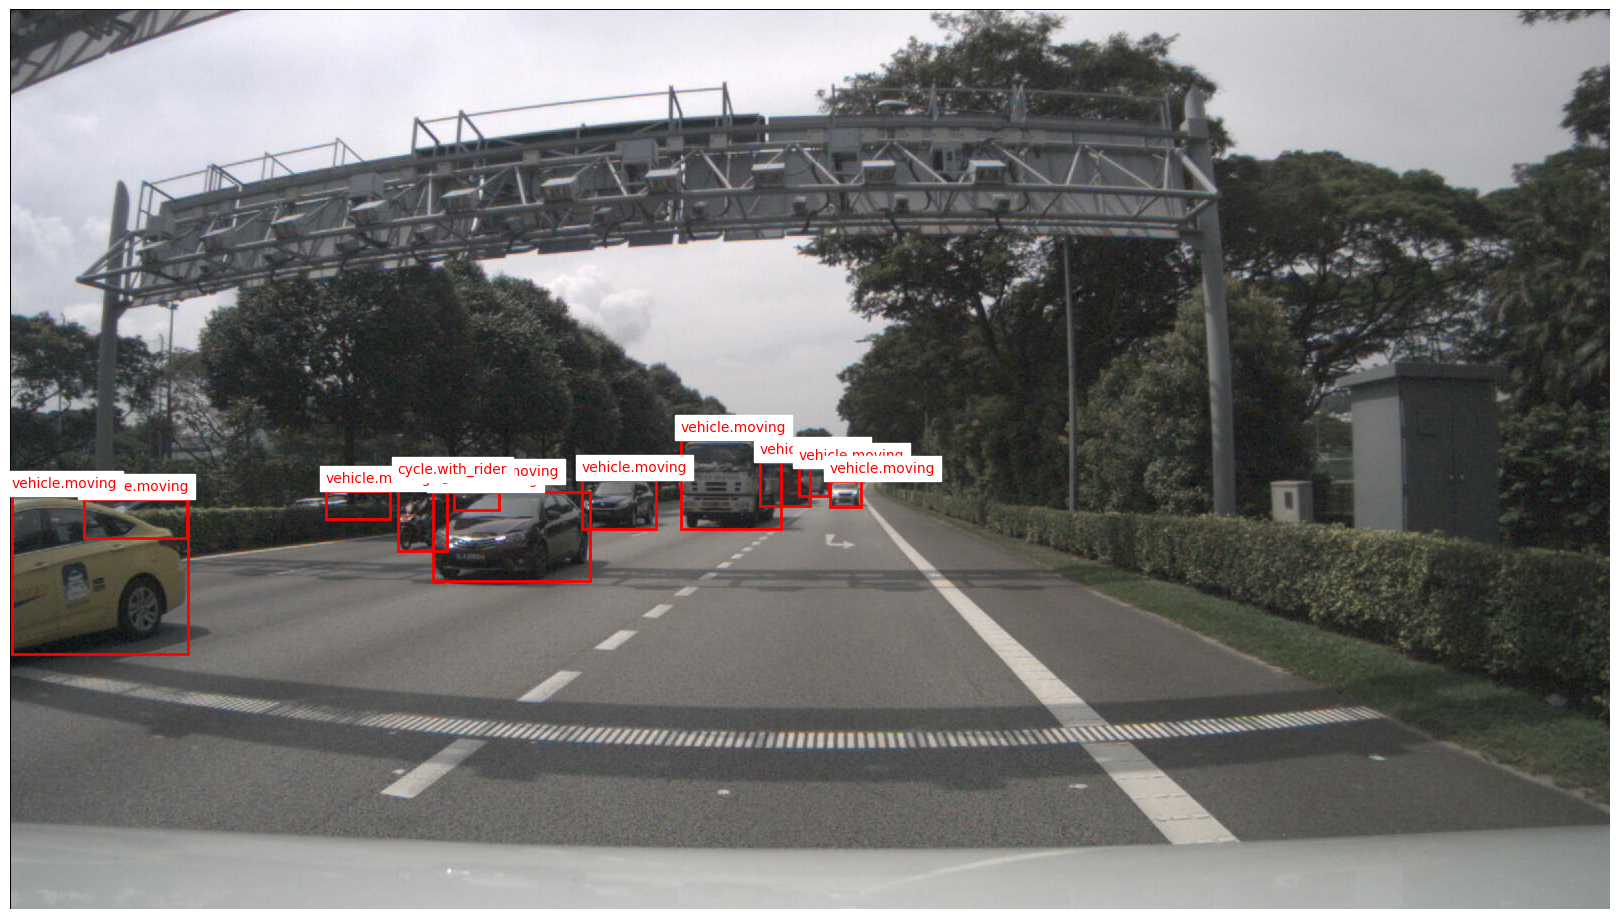

In [11]:
coco_json = '/content/train.json'
image_path = '/content/train2017/'
data_preparation.display_image_from_coco_json(coco_json, image_path)

# DETR with Detectron2

Made based on https://colab.research.google.com/github/woctezuma/finetune-detr/blob/master/finetune_detectron2.ipynb#scrollTo=E_zNl-FUArRr

In [12]:
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15900, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 15900 (delta 55), reused 19 (delta 19), pack-reused 15808 (from 5)
Receiving objects: 100% (15900/15900), 6.46 MiB | 22.49 MiB/s, done.
Resolving deltas: 100% (11563/11563), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.2 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=e1e6cf6af905925a1e0a31b7753d0d4b80da5ef25bd2b5dfb4a1823d9a88fbd1
  Stored in directory: /root/.cache

In [13]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [14]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "/content/train.json", "/content/train2017/")
register_coco_instances("my_dataset_val", {}, "/content/val.json", "/content/val2017/")

In [15]:
%cd /content/

!git clone https://github.com/facebookresearch/detr

%cd detr/

!python d2/converter.py --source_model https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth --output_model converted_model.pth

/content
Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Total 265 (delta 0), reused 0 (delta 0), pack-reused 265 (from 1)
Receiving objects: 100% (265/265), 21.19 MiB | 38.75 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/detr
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100% 159M/159M [00:00<00:00, 196MB/s]
transformer.encoder.layers.0.self_attn.in_proj_weight -> detr.transformer.encoder.layers.0.self_attn.in_proj_weight
transformer.encoder.layers.0.self_attn.in_proj_bias -> detr.transformer.encoder.layers.0.self_attn.in_proj_bias
transformer.encoder.layers.0.self_attn.out_proj.weight -> detr.transformer.encoder.layers.0.self_attn.out_proj.weight
transformer.encoder.layers.0.self_attn.out_proj.bias -> detr.transformer.encoder.layers.0.self_attn.out_proj.bias
transformer.encoder.layers.0.linear1.weight -> detr.transformer.encoder.layers.0.linear1.weight
transfo

In [16]:
from d2.detr import add_detr_config

cfg = get_cfg()

add_detr_config(cfg)
cfg.merge_from_file("d2/configs/detr_256_6_6_torchvision.yaml")

cfg.MODEL.WEIGHTS = "converted_model.pth"

In [17]:
%cd /content/detr/

/content/detr


In [18]:
from d2.detr import add_detr_config

cfg = get_cfg()

add_detr_config(cfg)
cfg.merge_from_file("d2/configs/detr_256_6_6_torchvision.yaml")

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.OUTPUT_DIR = '/content/outputs/'

cfg.MODEL.WEIGHTS = "/content/detr/converted_model.pth"
cfg.MODEL.DETR.NUM_CLASSES = len(class_list)

In [19]:
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.000125
# cfg.SOLVER.BASE_LR  = 0.02 * cfg.SOLVER.IMS_PER_BATCH / 16   # adjust per sweep
cfg.SOLVER.MAX_ITER    = int(61000 / cfg.SOLVER.IMS_PER_BATCH)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_list)

In [20]:
# from detectron2.engine import DefaultTrainer
from d2.train_net import Trainer

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/08 19:23:15 d2.engine.defaults]: Model:
Detr(
  (detr): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_

criterion.empty_weight
detr.class_embed.{bias, weight}


[07/08 19:23:25 d2.engine.train_loop]: Starting training from iteration 0
[07/08 19:23:38 d2.utils.events]:  eta: 0:59:29  iter: 19  total_loss: 295.1  loss_ce: 2.188  loss_bbox: 0.2447  loss_giou: 1.038  loss_ce_0: 2.776  loss_bbox_0: 0.2591  loss_giou_0: 1.076  loss_ce_1: 2.616  loss_bbox_1: 0.2504  loss_giou_1: 1.053  loss_ce_2: 2.492  loss_bbox_2: 0.2445  loss_giou_2: 1.039  loss_ce_3: 2.361  loss_bbox_3: 0.2451  loss_giou_3: 1.037  loss_ce_4: 2.26  loss_bbox_4: 0.2449  loss_giou_4: 1.05    time: 0.4733  last_time: 0.4413  data_time: 0.1459  last_data_time: 0.1435   lr: 0.000125  max_mem: 13861M
[07/08 19:23:51 d2.utils.events]:  eta: 0:59:03  iter: 39  total_loss: 162.2  loss_ce: 1.642  loss_bbox: 0.2248  loss_giou: 1.049  loss_ce_0: 1.984  loss_bbox_0: 0.2407  loss_giou_0: 1.084  loss_ce_1: 1.817  loss_bbox_1: 0.2233  loss_giou_1: 1.08  loss_ce_2: 1.734  loss_bbox_2: 0.221  loss_giou_2: 1.068  loss_ce_3: 1.701  loss_bbox_3: 0.2221  loss_giou_3: 1.064  loss_ce_4: 1.649  loss_bbox_

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
# how many images per forward pass
BATCH_SIZE  = 10           # try larger/smaller to match your GPU
NUM_WORKERS = 10           # CPU preprocessing threads

evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val",batch_size=BATCH_SIZE,
                num_workers=NUM_WORKERS)   # speeds up CPU ⇢ GPU pipeline)

print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

# NOTE: if you see NaN value: that (most likely) means the class doesn't exist in validation data, but exists in the training set data
# NOTE: if you see NaN value: that (most likely) means the class doesn't exist in validation data, but exists in the training set data
# especially you don't take 100% of the validation set

[07/02 21:48:21 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [07/02 21:48:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/02 21:48:24 d2.data.datasets.coco]: Loaded 14884 images in COCO format from /content/val.json
[07/02 21:48:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/02 21:48:25 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/02 21:48:25 d2.data.common]: Serializing 14884 elements to byte tensors and concatenating them all ...
[07/02 21:48:25 d2.data.common]: Serialized dataset takes 7.67 MiB
[07/02 21:48:25 d2.evaluation.evaluator]: Start inference on 1489 batches
[07/02 21:48:28 d2.evaluation.evaluator]: Inference done 11/1489. Dataloading: 0.0066 s/iter. Inference: 0